# Assignment 2

**Credits**: Federico Ruggeri, Eleonora Mancini, Paolo Torroni

**Keywords**: Human Value Detection, Multi-label classification, Transformers, BERT

# Imports and libraries needed

In [21]:
#%pip install nltk
#%pip install scikit-learn
%pip install transformers
#%pip install matplotlib
#%pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121

  Obtaining dependency information for transformers from https://files.pythonhosted.org/packages/12/dd/f17b11a93a9ca27728e12512d167eb1281c151c4c6881d3ab59eb58f4127/transformers-4.35.2-py3-none-any.whl.metadata
     ------------------------------------ 123.5/123.5 kB 258.6 kB/s eta 0:00:00
  Obtaining dependency information for huggingface-hub<1.0,>=0.16.4 from https://files.pythonhosted.org/packages/05/09/1945ca6ba3ad8ad6e2872ba682ce8d68c5e63c8e55458ed8ab4885709f1d/huggingface_hub-0.19.4-py3-none-any.whl.metadata
  Obtaining dependency information for pyyaml>=5.1 from https://files.pythonhosted.org/packages/24/97/9b59b43431f98d01806b288532da38099cc6f2fea0f3d712e21e269c0279/PyYAML-6.0.1-cp310-cp310-win_amd64.whl.metadata
  Obtaining dependency information for tokenizers<0.19,>=0.14 from https://files.pythonhosted.org/packages/42/db/0061fb8004ce9173b9249a0c323c799be51f2c8e6d4ff3cc38b549c3f8b6/tokenizers-0.15.0-cp310-none-win_amd64.whl.metadata
  Obtaining dependency information for safet


[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: C:\Users\alepa\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [2]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import random
import os
from sklearn.metrics import classification_report
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import string
import re
from sklearn.feature_extraction.text import  TfidfVectorizer

In [3]:
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'
print(f"Device: {device}")

Device: cuda


### Task 1: Corpus:

We address a multi-label classification problem. We consider only level 3 categories which are the following:
- Openness to change
- Self-enhancement
- Conservation
- Self-transcendence

We're gonna merge annotations of level 2 categories belonging to the same level 3 category. For example, we merge the annotations of the level 2 categories "Stimulation" and "Hedonism" into the level 3 category "Openness to change".

Encoding to pandas dataframe:

In [4]:
arg_train = pd.read_csv('arguments/arguments-training.tsv', sep='\t')
print(arg_train.head(1))
print(f"Shape of the training data: {arg_train.shape}")
arg_val = pd.read_csv('arguments/arguments-validation.tsv', sep='\t')
print(f"Shape of the validation data: {arg_val.shape}")
arg_test = pd.read_csv('arguments/arguments-test.tsv', sep='\t')
print(f"Shape of the test data: {arg_test.shape}")

  Argument ID                   Conclusion       Stance  \
0      A01002  We should ban human cloning  in favor of   

                                             Premise  
0  we should ban human cloning as it will only ca...  
Shape of the training data: (5393, 4)
Shape of the validation data: (1896, 4)
Shape of the test data: (1576, 4)


In [5]:
lab_train = pd.read_csv('arguments/labels-training.tsv', sep='\t')
print(lab_train.head(1))
print(f"Shape of the training data: {lab_train.shape}")
lab_val = pd.read_csv('arguments/labels-validation.tsv', sep='\t')
print(f"Shape of the validation data: {lab_val.shape}")
lab_test = pd.read_csv('arguments/labels-test.tsv', sep='\t')
print(f"Shape of the test data: {lab_test.shape}")

  Argument ID  Self-direction: thought  Self-direction: action  Stimulation  \
0      A01002                        0                       0            0   

   Hedonism  Achievement  Power: dominance  Power: resources  Face  \
0         0            0                 0                 0     0   

   Security: personal  ...  Tradition  Conformity: rules  \
0                   0  ...          0                  0   

   Conformity: interpersonal  Humility  Benevolence: caring  \
0                          0         0                    0   

   Benevolence: dependability  Universalism: concern  Universalism: nature  \
0                           0                      0                     0   

   Universalism: tolerance  Universalism: objectivity  
0                        0                          0  

[1 rows x 21 columns]
Shape of the training data: (5393, 21)
Shape of the validation data: (1896, 21)
Shape of the test data: (1576, 21)


Now for each split we merge arguments and labels into a single dataframe.

In [6]:
df_train = arg_train.merge(lab_train, on='Argument ID')
df_val = arg_val.merge(lab_val, on='Argument ID')
df_test = arg_test.merge(lab_test, on='Argument ID')
print(f"Shape of the training data: {df_train.shape}")
print(f"Shape of the validation data: {df_val.shape}")
print(f"Shape of the test data: {df_test.shape}")
print(df_train.head(1))

Shape of the training data: (5393, 24)
Shape of the validation data: (1896, 24)
Shape of the test data: (1576, 24)
  Argument ID                   Conclusion       Stance  \
0      A01002  We should ban human cloning  in favor of   

                                             Premise  Self-direction: thought  \
0  we should ban human cloning as it will only ca...                        0   

   Self-direction: action  Stimulation  Hedonism  Achievement  \
0                       0            0         0            0   

   Power: dominance  ...  Tradition  Conformity: rules  \
0                 0  ...          0                  0   

   Conformity: interpersonal  Humility  Benevolence: caring  \
0                          0         0                    0   

   Benevolence: dependability  Universalism: concern  Universalism: nature  \
0                           0                      0                     0   

   Universalism: tolerance  Universalism: objectivity  
0              

We merge level 2 categories into level 3 categories.

In [7]:
# Merge the level 2 categories to level 3
# They start from column 4 so we can just add 4 to the level 2 category
# Openness to change: 4 columns
# Conservation: columns 4 columns
# Self-enhancement: 6 columns
# Self-transcendence: 6 columns

def merge_categories(df):
    # Logical or 
    df['Openness to change'] = df[df.columns[4:8]].any(axis=1).astype(int)
    df['Conservation'] = df[df.columns[7:12]].any(axis=1).astype(int)
    df['Self-enhancement'] = df[df.columns[11:18]].any(axis=1).astype(int)
    df['Self-transcendence'] = df[df.columns[17:24]].any(axis=1).astype(int)

    #df['Openness to change'] = df[df.columns[4:8]].sum(axis=1)
    #df['Conservation'] = df[df.columns[8:12]].sum(axis=1)
    #df['Self-enhancement'] = df[df.columns[12:18]].sum(axis=1)
    #df['Self-transcendence'] = df[df.columns[18:24]].sum(axis=1)
    df = df.drop(df.columns[4:24], axis=1)
    return df

# get column names
df_train = merge_categories(df_train)
df_val = merge_categories(df_val)
df_test = merge_categories(df_test)
print(df_train.head(1))
print(f"Shape of the training data: {df_train.shape}")
print(f"Shape of the validation data: {df_val.shape}")
print(f"Shape of the test data: {df_test.shape}")

  Argument ID                   Conclusion       Stance  \
0      A01002  We should ban human cloning  in favor of   

                                             Premise  Openness to change  \
0  we should ban human cloning as it will only ca...                   0   

   Conservation  Self-enhancement  Self-transcendence  
0             0                 1                   0  
Shape of the training data: (5393, 8)
Shape of the validation data: (1896, 8)
Shape of the test data: (1576, 8)


In [8]:
df_test.loc[8]

Argument ID                                                      A26068
Conclusion                        We should subsidize stay-at-home dads
Stance                                                      in favor of
Premise               we should subsidize stay-at-home dads because ...
Openness to change                                                    1
Conservation                                                          0
Self-enhancement                                                      1
Self-transcendence                                                    1
Name: 8, dtype: object

### Text encoding:

In [9]:
nltk.download('punkt')
train_text = df_train['Premise'].tolist()
train_lengths = [len(word_tokenize(x)) for x in tqdm(train_text)]

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\alepa\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.
100%|██████████| 5393/5393 [00:00<00:00, 8413.42it/s] 


Plotting the distribution of the number of words per argument:

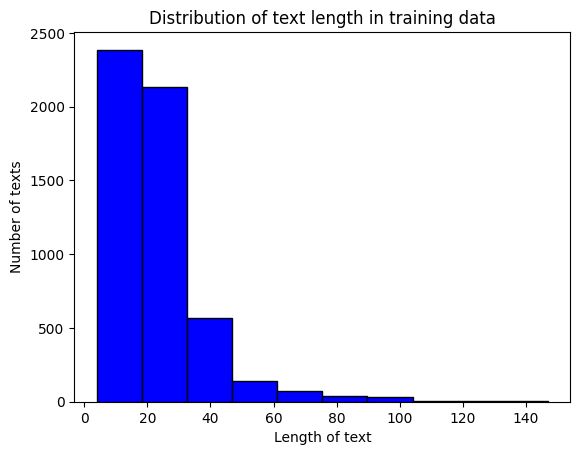

In [10]:
plt.hist(train_lengths, color='blue', edgecolor='black')
plt.xlabel('Length of text')
plt.ylabel('Number of texts')
plt.title('Distribution of text length in training data')
plt.show()

Text preproccesing with nltk:

In [11]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

lemmatizer = WordNetLemmatizer()
punct = string.punctuation
bad_symbols = re.compile('[^a-z ]')
stopwords = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\alepa\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\alepa\AppData\Roaming\nltk_data...
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\alepa\AppData\Roaming\nltk_data...


In [12]:
def preprocess(text):
    text = text.lower()
    text = bad_symbols.sub('', text)
    text = ' '.join(word for word in text.split() if word not in punct)
    text = ' '.join(word for word in text.split() if word not in stopwords)
    text = ' '.join(lemmatizer.lemmatize(word) for word in text.split())
    return text

In [13]:
train = df_train.copy()
train['Preprocessed'] = train['Premise'].apply(preprocess)
print(train['Preprocessed'][0])
train = train.drop(columns=train.columns[1:4])
train.head(1)
val = df_val.copy()
val['Preprocessed'] = val['Premise'].apply(preprocess)
val = val.drop(columns=val.columns[1:4])
test = df_test.copy()
test['Preprocessed'] = test['Premise'].apply(preprocess)
test = test.drop(columns=test.columns[1:4])

ban human cloning cause huge issue bunch human running around acting


In [14]:
train.head(1)

,Argument ID,Openness to change,Conservation,Self-enhancement,Self-transcendence,Preprocessed
0,A01002,0,0,1,0,ban human cloning cause huge issue bunch human...


In [15]:
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(train['Preprocessed'])
print(f"Shape of the training data: {X_train.shape}")
print(f"Size of the vocabulary: {len(vectorizer.vocabulary_)}")
X_val = vectorizer.transform(val['Preprocessed'])
X_test = vectorizer.transform(test['Preprocessed'])

Shape of the training data: (5393, 6836)
Size of the vocabulary: 6836


In [16]:
print(f"Shape of the validation data: {X_val.shape}")
print(f"Shape of the test data: {X_test.shape}")

Shape of the validation data: (1896, 6836)
Shape of the test data: (1576, 6836)


# Task 2: Model definition

You are tasked to define several neural models for multi-label classification.

### Instructions

* **Baseline**: implement a random uniform classifier (an individual classifier per category).
* **Baseline**: implement a majority classifier (an individual classifier per category).

<br/>

* **BERT w/ C**: define a BERT-based classifier that receives an argument **conclusion** as input.
* **BERT w/ CP**: add argument **premise** as an additional input.
* **BERT w/ CPS**: add argument premise-to-conclusion **stance** as an additional input.

Evaluation report for baseline models:

In [17]:
def evaluate(Y_test, Y_pred):
    report = classification_report(Y_test, Y_pred)
    print(report)

Y_test = test.iloc[:, 1:5].values # get as array the labels of the test set [oppenness, conservation, self-enhancement, self-transcendence]
Y_val = val.iloc[:, 1:5].values # get as array the labels of the validation set [oppenness, conservation, self-enhancement, self-transcendence]

### Implement a random uniform classifier:

In [18]:
from sklearn.dummy import DummyClassifier

uniform_classifier_openness = DummyClassifier(strategy='uniform')
uniform_classifier_conserv = DummyClassifier(strategy='uniform')
uniform_classifier_self_enh = DummyClassifier(strategy='uniform')
uniform_classifier_self_trans = DummyClassifier(strategy='uniform')

### Implement a majority classifier:

In [19]:
majority_classifier_openness = DummyClassifier(strategy='most_frequent')
majority_classifier_conserv = DummyClassifier(strategy='most_frequent')
majority_classifier_self_enh = DummyClassifier(strategy='most_frequent')
majority_classifier_self_trans = DummyClassifier(strategy='most_frequent')

### RoBERTa model:

In [22]:
import torch
import transformers
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from transformers import AutoModel, AutoTokenizer, get_linear_schedule_with_warmup, RobertaConfig
from torch import cuda

C:\Users\alepa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Global variables:

In [23]:
model_name = 'roberta-base'
max_len = 100
batch_size = 16
epochs = 10
learning_rate = 2e-5
output_channels = 768
tokenizer = AutoTokenizer.from_pretrained(model_name)

config.json: 100%|██████████| 481/481 [00:00<?, ?B/s] 
vocab.json: 100%|██████████| 899k/899k [00:00<00:00, 2.20MB/s]
merges.txt: 100%|██████████| 456k/456k [00:00<00:00, 1.53MB/s]
tokenizer.json: 100%|██████████| 1.36M/1.36M [00:00<00:00, 2.67MB/s]


Token generation for RoBERTa:

In [24]:
class RobertaDataset(Dataset):
    def __init__(self, data, labels, tokenizer, max_len):
        self.data = data
        self.targets = labels
        self.tokenizer = tokenizer
        self.max_len = max_len
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        text = str(self.data[index])
        text = ' '.join(text.split())

        inputs = self.tokenizer.encode_plus(
            text,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            truncation=True,
            padding='max_length',
            return_token_type_ids=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs["token_type_ids"]
        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'targets': torch.tensor(self.targets[index], dtype=torch.float)
        }

# Create the dataset for the neural network
train_targets = df_train.iloc[:, 4:8].values
val_targets = df_val.iloc[:, 4:8].values
test_targets = df_test.iloc[:, 4:8].values

print(f"Shape of the training labels: {train_targets.shape}")
print(f"Shape of the validation labels: {val_targets.shape}")
print(f"Shape of the test labels: {test_targets.shape}")

Shape of the training labels: (5393, 4)
Shape of the validation labels: (1896, 4)
Shape of the test labels: (1576, 4)


RoBERTa model definition: 

In [25]:
class roBERTa(torch.nn.Module):
    def __init__(self, model_name):
        super(roBERTa, self).__init__()
        self.roberta = AutoModel.from_pretrained(model_name, return_dict=False)
        self.dropout = torch.nn.Dropout(p=0.3)
        self.classifier = torch.nn.Linear(output_channels, 4)
        
    def forward(self, ids, mask, token_type_ids):
        _, output = self.roberta(ids, attention_mask=mask, token_type_ids=token_type_ids)
        output = self.dropout(output)
        output = self.classifier(output)
        return output

Loss function:

In [26]:
def loss_fn(outputs, targets):
    return torch.nn.BCEWithLogitsLoss()(outputs, targets)

RoBERTa w/C data preparation:

In [52]:
train_datasetc = RobertaDataset(df_train.iloc[:, 1], train_targets, tokenizer, max_len)
val_datasetc = RobertaDataset(df_val.iloc[:, 1], val_targets, tokenizer, max_len)
test_datasetc = RobertaDataset(df_test.iloc[:, 1], test_targets, tokenizer, max_len)

print(f"Shape of the training dataset: {len(train_datasetc)}")
print(f"Shape of the validation dataset: {len(val_datasetc)}")
print(f"Shape of the test dataset: {len(test_datasetc)}")

train_dataloaderc = DataLoader(train_datasetc, batch_size=batch_size)
val_dataloaderc = DataLoader(val_datasetc, batch_size=batch_size)
test_dataloaderc = DataLoader(test_datasetc, batch_size=batch_size)


Shape of the training dataset: 5393
Shape of the validation dataset: 1896
Shape of the test dataset: 1576


Using gpu if available:

In [28]:
model_c = roBERTa(model_name)
model_c.to(device)

model.safetensors: 100%|██████████| 499M/499M [00:09<00:00, 54.7MB/s] 
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


roBERTa(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((

Training RoBERTa w/C:

In [54]:
optimizer = torch.optim.Adam(params=model_c.parameters(), lr=learning_rate)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=len(train_dataloaderc)*epochs)

def trainBert(model):
    size = len(train_dataloaderc.dataset)
    model.train()
    for batch, data in enumerate(train_dataloaderc, 0):
        ids = data['ids'].to(device, dtype=torch.long)
        mask = data['mask'].to(device, dtype=torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype=torch.long)
        targets = data['targets'].to(device, dtype=torch.float)

        outputs = model_c(ids, mask, token_type_ids)
        loss = loss_fn(outputs, targets)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()
        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(ids)
            print(f"Train loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

Validation RoBERTa w/C:

In [56]:
def validation(epoch, val_loss_min_input, model):
    size = len(test_dataloaderc.dataset)
    num_batches = len(test_dataloaderc)
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch_idx, data in enumerate(test_dataloaderc, 0):
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
            targets = data['targets'].to(device, dtype = torch.float)
            outputs = model_c(ids, mask, token_type_ids)
            val_loss += loss_fn(outputs, targets).item()
        
        val_loss /= num_batches
        #outputs, targets = fin_outputs, fin_targets
        print(f"\nValidation loss: {val_loss:>8f}.")
        ## TODO: save the model if validation loss has decreased
        if val_loss <= val_loss_min_input:
            #create checkpoint variable and add important data
            if epoch > 0: 
                print('Validation loss decreased ({:.8f} --> {:.8f}).  Saving model ...'.format(val_loss_min_input, val_loss))
            else: print('Saving model ...')   
            # save best moel
            torch.save(model.state_dict(), "model_c.pth")
            print("Saved PyTorch Model State to model.pth\n")
            val_loss_min_input = val_loss
    
    return val_loss_min_input

RoBERTa w/CP data preparation:

In [45]:
train_datasetp = RobertaDataset(df_train.iloc[:, 3], train_targets, tokenizer, max_len)
val_datasetp = RobertaDataset(df_val.iloc[:, 3], val_targets, tokenizer, max_len)
test_datasetp = RobertaDataset(df_test.iloc[:, 3], test_targets, tokenizer, max_len)

print(f"Shape of the training dataset: {len(train_datasetp)}")
print(f"Shape of the validation dataset: {len(val_datasetp)}")
print(f"Shape of the test dataset: {len(test_datasetp)}")

train_dataloaderp = DataLoader(train_datasetp, batch_size=batch_size)
val_dataloaderp = DataLoader(val_datasetp, batch_size=batch_size)
test_dataloaderp = DataLoader(test_datasetp, batch_size=batch_size)

Shape of the training dataset: 5393
Shape of the validation dataset: 1896
Shape of the test dataset: 1576


In [59]:
batch = next(iter(train_dataloaderp))

ids = batch["ids"].to(device)
mask = batch["mask"].to(device)
target = batch["targets"].to(device)
token = batch["token_type_ids"].to(device)
# boooooooohh raga
output = model_c(ids, mask, token)
output

tensor([[ 0.1828,  0.2094, -0.0038, -0.0573],
        [ 0.0874,  0.0400, -0.0721, -0.0200],
        [ 0.0093,  0.1461, -0.0029,  0.0195],
        [-0.1033,  0.0264,  0.0550,  0.0222],
        [-0.1014,  0.1246, -0.0914, -0.0866],
        [-0.0512,  0.1199,  0.1506,  0.0140],
        [ 0.0833,  0.2248,  0.1292,  0.0194],
        [ 0.0859,  0.1430,  0.0661,  0.0882],
        [ 0.0087,  0.0444,  0.1451,  0.0614],
        [-0.0438,  0.0545,  0.0341, -0.0201],
        [-0.0754,  0.0271,  0.0386, -0.0585],
        [ 0.0457,  0.0245,  0.0587,  0.0460],
        [-0.0337,  0.0333,  0.1333,  0.1547],
        [ 0.0335,  0.0614,  0.0291,  0.0642],
        [-0.0490, -0.0449,  0.0747,  0.1677],
        [-0.0291, -0.0582,  0.1032,  0.0370]], device='cuda:0',
       grad_fn=<AddmmBackward0>)

Using gpu if available:

In [32]:
model_cp = roBERTa(model_name)
model_cp.to(device)

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


roBERTa(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((

# Task 3: Metrics

Before training the models, you are tasked to define the evaluation metrics for comparison.

### Instructions

* Evaluate your models using per-category binary F1-score.
* Compute the average binary F1-score over all categories (macro F1-score).

### Random uniform classifier metrics:

In [33]:
def f1scoreRandom(X_val, Y_val):
    Y_pred_openness_unif = uniform_classifier_openness.predict(X_val)
    Y_pred_conserv_unif = uniform_classifier_conserv.predict(X_val)
    Y_pred_self_enh_unif = uniform_classifier_self_enh.predict(X_val)
    Y_pred_self_trans_unif = uniform_classifier_self_trans.predict(X_val)
    
    Y_pred = []
    for i in range(len(Y_pred_openness_unif)):
        temp = []
        temp.append(Y_pred_openness_unif[i])
        temp.append(Y_pred_conserv_unif[i])
        temp.append(Y_pred_self_enh_unif[i])
        temp.append(Y_pred_self_trans_unif[i])
        Y_pred.append(temp)
        
    return evaluate(Y_val, Y_pred)

### Majority classifier metrics:

In [34]:
def f1scoreMajority(X_val, Y_val):
    Y_pred_openness_maj = majority_classifier_openness.predict(X_val)
    Y_pred_conserv_maj = majority_classifier_conserv.predict(X_val)
    Y_pred_self_enh_maj = majority_classifier_self_enh.predict(X_val)
    Y_pred_self_trans_maj = majority_classifier_self_trans.predict(X_val)

    Y_pred = []
    for i in range(len(Y_pred_openness_maj)):
        temp = []
        temp.append(Y_pred_openness_maj[i])
        temp.append(Y_pred_conserv_maj[i])
        temp.append(Y_pred_self_enh_maj[i])
        temp.append(Y_pred_self_trans_maj[i])
        Y_pred.append(temp)
        
    return evaluate(Y_val, Y_pred)

In [35]:
def test(model, testing_loader):
    model.eval()
    fin_targets=[]
    fin_outputs=[]
    with torch.no_grad():
        for _, data in enumerate(testing_loader, 0):
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
            targets = data['targets'].to(device, dtype = torch.float)
            outputs = model(ids, mask, token_type_ids)
            fin_targets.extend(targets.cpu().detach().numpy().tolist())
            fin_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())
    return fin_outputs, fin_targets

# Task 4: Training and Evaluation

You are now tasked to train and evaluate **all** defined models.

### Instructions

* Train **all** models on the train set.
* Evaluate **all** models on the validation set.
* Pick **at least** three seeds for robust estimation.
* Compute metrics on the validation set.
* Report **per-category** and **macro** F1-score for comparison.

In [36]:
# Seed definition
#seed = 42
#seed = 69
seed = 420

# Set the seed for numpy and tensorflow
np.random.seed(seed)

### Train the random uniform classifier:

In [37]:

Y_train_openness = train['Openness to change']
Y_train_conserv = train['Conservation']
Y_train_self_enh = train['Self-enhancement']
Y_train_self_trans = train['Self-transcendence']
uniform_classifier_openness.fit(X_train, Y_train_openness)
uniform_classifier_conserv.fit(X_train, Y_train_conserv)
uniform_classifier_self_enh.fit(X_train, Y_train_self_enh)
uniform_classifier_self_trans.fit(X_train, Y_train_self_trans)

DummyClassifier(strategy='uniform')

In [ ]:
f1scoreRandom(X_val, Y_val)

### Train the majority classifier:

In [38]:
majority_classifier_openness.fit(X_train, Y_train_openness)
majority_classifier_conserv.fit(X_train, Y_train_conserv)
majority_classifier_self_enh.fit(X_train, Y_train_self_enh)
majority_classifier_self_trans.fit(X_train, Y_train_self_trans)

DummyClassifier(strategy='most_frequent')

In [39]:
f1scoreMajority(X_val, Y_val)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       698
           1       0.00      0.00      0.00       885
           2       0.75      1.00      0.86      1426
           3       0.79      1.00      0.89      1506

   micro avg       0.77      0.65      0.71      4515
   macro avg       0.39      0.50      0.44      4515
weighted avg       0.50      0.65      0.57      4515
 samples avg       0.77      0.68      0.70      4515



C:\Users\alepa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Training RoBERTa w/C:

In [ ]:
val_loss_min = np.Inf
for epoch in range(epochs):
    print(f"Epoch {epoch + 1}\n-------------------------------")
    trainBert(model_c)
    val_loss_min = validation(epoch, val_loss_min, model_c)

### Training RoBERTa w/C:

In [ ]:
val_loss_min = np.Inf
for epoch in range(epochs):
    print(f"Epoch {epoch + 1}\n-------------------------------")
    trainBert(model_cp)
    val_loss_min = validation(epoch, val_loss_min, model_cp)

### RoBERTa w/C evaluation:

In [ ]:
# Threshold 
from sklearn.metrics import f1_score

outputs_c, targets_c = test(model_c, val_dataloader)
results_c = {}
for tr in np.arange(0.1, 0.9, 0.1):
    tr = round(tr, 2)
    predictions_c = np.array(outputs_c) >= tr
    f1_c = f1_score(targets_c, predictions_c, average='macro', zero_division=1)
    results_c[tr] = f1_c

for k, v in results_c.items():
    print(f"Threshold: {k}, F1-score: {v}")

In [ ]:
th = max(results_c, key=results_c.get)
print(f"Best threshold: {th}, F1-score: {results_c[th]}")
predictions_c = np.array(outputs_c) >= th
labels = ['Openness to change', 'Conservation', 'Self-enhancement', 'Self-transcendence']
print(classification_report(targets_c, predictions_c, target_names=labels ,zero_division=1))

# Task 5: Error Analysis

You are tasked to discuss your results.

### Instructions

* **Compare** classification performance of BERT-based models with respect to baselines.
* Discuss **difference in prediction** between the best performing BERT-based model and its variants.

# Task 6: Report

Wrap up your experiment in a short report (up to 2 pages).

### Instructions

* Use the NLP course report template.
* Summarize each task in the report following the provided template.